In [2]:
%load_ext autoreload
%autoreload 2

import torch
import numpy as np
from transformers import AutoModelForCausalLM, AutoTokenizer

/home/ubuntu/document/general-task-vectors/.venv/lib/python3.10/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


### Some configs

In [4]:
MODEL_NAME = 'gpt2'
# MODEL_NAME = 'microsoft/phi-2'
# MODEL_NAME = 'EleutherAI/pythia-1B'
MODEL_NAME = 'stabilityai/stablelm-2-zephyr-1_6b'

LOAD_IN_8BIT = True
RELATIVE_PATH = '../'

dataset_name = 'country-capital'
# select number of ICL examples (query excluded)
ICL_examples = 2
debug = True

### dataset

In [4]:
import json

def load_json_dataset(json_path):
    with open(json_path, encoding='utf-8') as file:
        dataset = json.load(file)
    return dataset

dataset = load_json_dataset(f'{RELATIVE_PATH}data/{dataset_name}.json')
dataset = list(map(lambda x: tuple(x.values()), dataset))

if debug:
    dataset = dataset[0:50]

print(f'dataset len: {len(dataset)}')

dataset len: 50


In [5]:
import sys
sys.path.append('..')
torch.set_grad_enabled(False)

from src.utils.model_utils import load_gpt_model_and_tokenizer, set_seed
from src.extraction import get_mean_activations
from src.utils.prompt_helper import tokenize_ICL
from src.intervention import compute_indirect_effect
set_seed(32)

In [6]:
model, tokenizer, config, device = load_gpt_model_and_tokenizer(MODEL_NAME, LOAD_IN_8BIT)
tok_ret, ids_ret, correct_labels = tokenize_ICL(tokenizer, ICL_examples = ICL_examples, dataset = dataset)

[x] Loading model manually to fix trust_remote_code issue when loading


## Get activations and measure head's importance

In [7]:
print(len(
    (
        [0, 1, 2, 5, 6, 7, 8, 11, 12, 13, 14, 17, 18, 19, 20, 23, 24, 25, 26, 28, 29, 30, 31], 
        [0, 1, 2, 7, 8, 9, 10, 12, 13, 14, 15, 17, 18, 19, 20, 22, 23, 24, 25, 29, 30, 31, 32], 
        [0, 1, 2, 6, 7, 8, 9, 10, 11, 12, 13, 16, 17, 18, 19, 22, 23, 24, 25, 27, 28, 29, 30], 
        [0, 1, 2, 4, 5, 6, 7, 9, 10, 11, 12, 14, 15, 16, 17, 20, 21, 22, 23, 26, 27, 28, 29], 
        [0, 1, 2, 4, 5, 6, 7, 9, 10, 11, 12, 15, 16, 17, 18, 20, 21, 22, 23, 27, 28, 29, 30], 
        [0, 1, 2, 4, 5, 6, 7, 9, 10, 11, 12, 14, 15, 16, 17, 19, 20, 21, 22, 26, 27, 28, 29], 
        [0, 1, 2, 6, 7, 8, 9, 11, 12, 13, 14, 18, 19, 20, 21, 24, 25, 26, 27, 29, 30, 31, 32], [0, 1, 2, 6, 7, 8, 9, 16, 17, 18, 19, 22, 23, 24, 25, 27, 28, 29, 30, 33, 34, 35, 36], [0, 1, 2, 8, 9, 10, 11, 13, 14, 15, 16, 19, 20, 21, 22, 25, 26, 27, 28, 34, 35, 36, 37], [0, 1, 2, 6, 7, 8, 9, 11, 12, 13, 14, 17, 18, 19, 20, 23, 24, 25, 26, 30, 31, 32, 33], [0, 1, 2, 5, 6, 7, 8, 10, 11, 12, 13, 16, 17, 18, 19, 20, 21, 22, 23, 25, 26, 27, 28], [0, 1, 2, 6, 7, 8, 9, 11, 12, 13, 14, 16, 17, 18, 19, 21, 22, 23, 24, 26, 27, 28, 29], [0, 1, 2, 6, 7, 8, 9, 12, 13, 14, 15, 17, 18, 19, 20, 23, 24, 25, 26, 29, 30, 31, 32], [0, 1, 2, 4, 5, 6, 7, 10, 11, 12, 13, 20, 21, 22, 23, 29, 30, 31, 32, 35, 36, 37, 38], [0, 1, 2, 4, 5, 6, 7, 9, 10, 11, 12, 15, 16, 17, 18, 20, 21, 22, 23, 25, 26, 27, 28], [0, 1, 2, 5, 6, 7, 8, 13, 14, 15, 16, 18, 19, 20, 21, 23, 24, 25, 26, 32, 33, 34, 35])))


16


In [8]:
import os
if os.path.isfile(
    f'{RELATIVE_PATH}output/{dataset_name}_mean_activations_{MODEL_NAME.replace("/", "-")}_ICL{ICL_examples}.pt'
):
    mean_activations = torch.load(f'{RELATIVE_PATH}output/{dataset_name}_mean_activations_{MODEL_NAME.replace("/", "-")}_ICL{ICL_examples}.pt')
    mean_activations = mean_activations.to(device)
else:
    mean_activations = get_mean_activations(
        tokenized_prompts=tok_ret,
        important_ids=ids_ret,
        tokenizer=tokenizer,
        model=model,
        config=config,
        correct_labels=correct_labels,
        device='cuda',
    )
mean_activations.shape

[x] Extracting activations:   0%|          | 0/16 [00:00<?, ?it/s]

[x] Extracting activations (layer: 23/24): 100%|██████████| 16/16 [00:19<00:00,  1.19s/it]

[x] Model accuracy: 0.56, using 9 (out of 16) examples to compute mean activations


torch.Size([24, 32, 23, 64])

In [ ]:
cie, probs_original, probs_edited  = compute_indirect_effect(
    model=model,
    tokenizer=tokenizer,
    config=config,
    dataset=dataset, 
    mean_activations=mean_activations,
    ICL_examples = ICL_examples,
    batch_size=22,
)

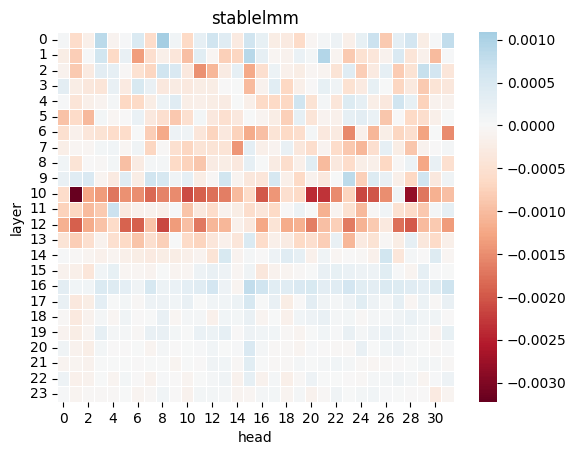

In [7]:
import torch
import seaborn as sns
import matplotlib.pylab as plt

cie = torch.load(f'{RELATIVE_PATH}output/antonym_cie_stabilityai-stablelm-2-zephyr-1_6b_ICL10.pt')

ax = sns.heatmap(cie.mean(dim=0), linewidth=0.5, cmap='RdBu', center = 0)
plt.title('stablelmm')
plt.xlabel('head')
plt.ylabel('layer')
plt.show()